In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
import glob
import os
import sys

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import generate_mocks as gm
import dipole

#### questions
1. Under what conditions do we need to regularize / when is regularization justified?
2. What impact does "excess" power and shot noise have on the measured $C_\ell$ and measured $a_{\ell m}$?
3. Confirm that the measured $a_{\ell m}$ coefficients are unbiased, but that the measured $C_\ell$ are positively biased?

#### helper function

In [20]:
def get_mock_fns(set_name, result_type, excess_mode, selfunc_mode, dipamp, base_rate):
    dir_results = os.path.join(f'/scratch/aew492/lss-dipoles_results/results/results_mocks', set_name)
    pattern = f"{dir_results}/{result_type}*_case-{excess_mode}-{selfunc_mode}-{dipamp:.4f}-{base_rate:.3f}*.npy"
    fns_mock = glob.glob(pattern)
    print(f"found {len(fns_mock)} files for this mock case: {pattern}")
    return fns_mock

#### Case 1. shot noise on the full sky

In [31]:
Lambdas = [0., 1e-6, 1e-3, 1e-2, 1e-1]
set_name = 'shot_noise_catwise'

Cells_res = []
for i, Lambda in enumerate(Lambdas):
    fns = get_mock_fns(set_name, f'Cells_Lambda-{Lambda:.1e}', 'zeros', 'ones', 0., 72.42)
    
    Cells = []
    for i, fn in enumerate(fns):
        res = np.load(fn, allow_pickle=True).item()
        Cells.append(res['Cells'][1:])
    ells = res['ells'][1:]
    
    mean_Cells = np.mean(np.array(Cells), axis=0)
    std_Cells = np.std(np.array(Cells), axis=0)

    res_dict = {
        'ells' : ells,
        'Cells' : Cells,
        'mean_Cells' : mean_Cells,
        'std_Cells' : std_Cells,
        'Lambda' : Lambda
    }
    Cells_res.append(res_dict)

found 12 files for this mock case: /scratch/aew492/lss-dipoles_results/results/results_mocks/shot_noise_catwise/Cells_Lambda-0.0e+00*_case-zeros-ones-0.0000-72.420*.npy
found 12 files for this mock case: /scratch/aew492/lss-dipoles_results/results/results_mocks/shot_noise_catwise/Cells_Lambda-1.0e-06*_case-zeros-ones-0.0000-72.420*.npy
found 12 files for this mock case: /scratch/aew492/lss-dipoles_results/results/results_mocks/shot_noise_catwise/Cells_Lambda-1.0e-03*_case-zeros-ones-0.0000-72.420*.npy
found 12 files for this mock case: /scratch/aew492/lss-dipoles_results/results/results_mocks/shot_noise_catwise/Cells_Lambda-1.0e-02*_case-zeros-ones-0.0000-72.420*.npy
found 12 files for this mock case: /scratch/aew492/lss-dipoles_results/results/results_mocks/shot_noise_catwise/Cells_Lambda-1.0e-01*_case-zeros-ones-0.0000-72.420*.npy


ValueError: Invalid vmin or vmax

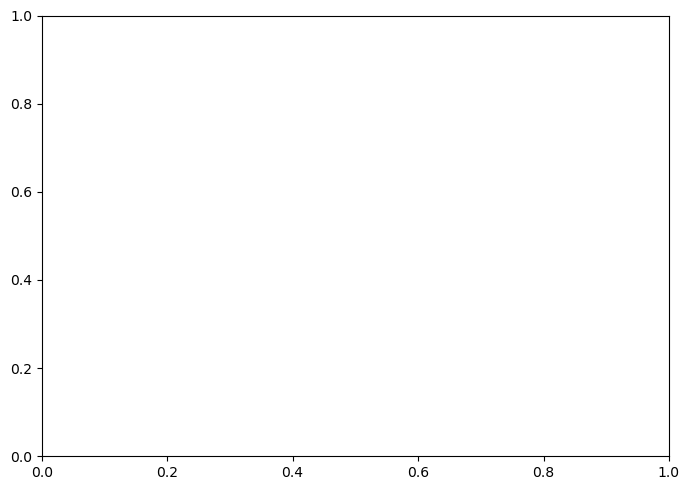

In [32]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
norm = mpl.colors.LogNorm(vmin=min(Lambdas), vmax=max(Lambdas))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

kwargs = dict(marker='s', ls='None', capsize=2, lw=0.5, alpha=0.7)
for res_dict in Cells_res:
    Lambda = res_dict['Lambda']
    ax.errorbar(ells, res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=smap.to_rgba(Lambda),
                label='$\Lambda=$'f'{Lambda:.1e}', **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name}')